In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
train=pd.read_csv('train.csv',index_col=0,parse_dates=True)
test=pd.read_csv('test.csv',index_col=0,parse_dates=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
Open      20 non-null float64
High      20 non-null float64
Low       20 non-null float64
Close     20 non-null float64
Volume    20 non-null object
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


In [3]:
def str_to_float(row):
        try:
            row['Volume'] = float(row['Volume'].replace(',',''))
        except:
            row['Volume'] = row['Volume']
        return row

train = train.apply(str_to_float, axis = 1)

In [4]:
def str_to_float(row):        
        try:
            row['Close'] = float(row['Close'].replace(',',''))
        except:
            row['Close'] = row['Close']
        return row
train = train.apply(str_to_float, axis = 1)

In [5]:
def str_to_float(row):
        try:
            row['Volume'] = float(row['Volume'].replace(',',''))
        except:
            row['Volume'] = row['Volume']
        return row
test = test.apply(str_to_float, axis = 1)

In [6]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null float64
dtypes: float64(5)
memory usage: 59.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
Open      20 non-null float64
High      20 non-null float64
Low       20 non-null float64
Close     20 non-null float64
Volume    20 non-null float64
dtypes: float64(5)
memory usage: 960.0 bytes


In [7]:
train=train.asfreq(freq='D',method='pad')

In [8]:
train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,7380500.0
2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2012-01-05,329.83,330.75,326.89,657.21,6590300.0
2012-01-06,328.34,328.77,323.68,648.24,5405900.0
2012-01-07,328.34,328.77,323.68,648.24,5405900.0


[Text(0, 0.5, 'Closing Price'), Text(0.5, 0, '')]

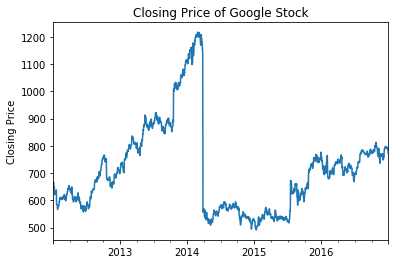

In [9]:
price=train['Close']
ax=price.plot()
ax.set_title('Closing Price of Google Stock')
xlabel=''
ylabel='Closing Price'
ax.set(xlabel=xlabel,ylabel=ylabel)

In [10]:
train.diff().idxmin()

Open     2015-08-24
High     2016-02-04
Low      2015-08-24
Close    2014-03-27
Volume   2013-10-21
dtype: datetime64[ns]

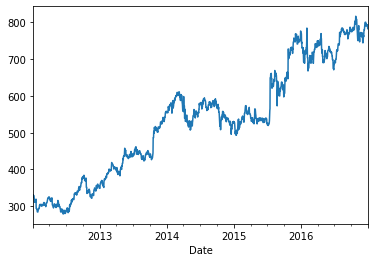

In [11]:
train['Open'].plot()

## RNN

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_train_open=scaler.fit_transform(train[['Open']])
scaled_test_open=scaler.transform(test[['Open']])

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train_open, scaled_train_open, length=n_input, batch_size=1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit_generator(generator,epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1812 steps
Epoch 1/30
1812/1812 [==============================] - 24s 13ms/step - loss: 0.0027
Epoch 2/30
1812/1812 [==============================] - 16s 9ms/step - loss: 7.2264e-04
Epoch 3/30
1812/1812 [==============================] - 12s 7ms/step - loss: 6.4944e-04
Epoch 4/30
1812/1812 [==============================] - 11s 6ms/step - loss: 4.6096e-04
Epoch 5/30
1812/1812 [==============================] - ETA: 0s - loss: 3.9003e-0 - 11s 6ms/step - loss: 3.8945e-04
Epoch 6/30
1812/1812 [==============================] - 11s 6ms/step - loss: 3.5017e-04
Epoch 7/30
1812/1812 [==============================] - 12s 6ms/step - loss: 3.0990e-04
Epoch 8/30
1812/1812 [==============================] - 12s 7ms/step - loss: 3.2918e-04
Epoch 9/30
1812/1812 [==============================] - 13s 7ms/step - loss: 3.1547e-04: 0s - loss: 3. - ETA: 0s - loss:
Epoch 10/30
1812/1812 [=====

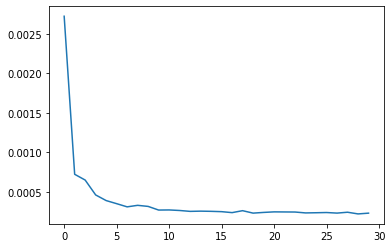

In [18]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [19]:
test_predictions = []

first_eval_batch = scaled_train_open[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predicted Open']=true_predictions

In [21]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
error1 = mean_squared_error(test['Predicted Open'], test['Open'])
error2 = rmse(test['Predicted Open'], test['Open'])
print(f'RNN Mean Squared Error: {error1:11.10}')
print(f'RNN Root Mean Squared Error: {error2:11.10}')

RNN Mean Squared Error: 2133.420562
RNN Root Mean Squared Error:  46.1889658


In [22]:
test.head()

,Open,High,Low,Close,Volume,Predicted Open
Date,,,,,,
2017-01-03,778.81,789.63,775.80,786.14,1657300.0,781.394480
2017-01-04,788.36,791.34,783.16,786.90,1073000.0,779.858431
2017-01-05,786.08,794.48,785.02,794.02,1335200.0,778.427765
2017-01-06,795.26,807.90,792.20,806.15,1640200.0,776.983386
2017-01-09,806.40,809.97,802.83,806.65,1272400.0,775.514751


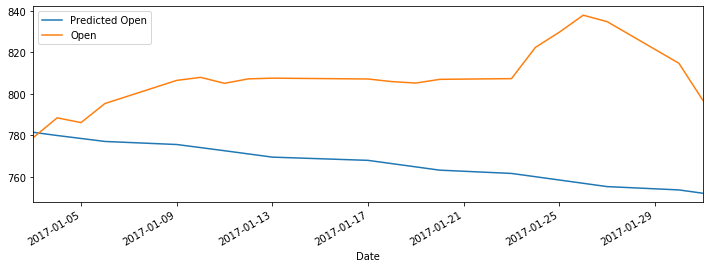

In [23]:
test['Predicted Open'].plot(figsize=(12,4),legend=True)
test['Open'].plot(figsize=(12,4),legend=True)

In [24]:
Closing_price=train['Close'].loc['2014-03-27':]
scaled_train_close=scaler.fit_transform(pd.DataFrame(Closing_price))
scaled_test_close=scaler.transform(test[['Close']])

In [25]:
n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train_close, scaled_train_close, length=n_input, batch_size=1)

In [26]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.fit_generator(generator,epochs=30)

  ...
    to  
  ['...']
Train for 998 steps
Epoch 1/30
998/998 [==============================] - 17s 17ms/step - loss: 0.0070
Epoch 2/30
998/998 [==============================] - 9s 9ms/step - loss: 0.0021
Epoch 3/30
998/998 [==============================] - 8s 8ms/step - loss: 0.0018
Epoch 4/30
998/998 [==============================] - 6s 6ms/step - loss: 0.0013
Epoch 5/30
998/998 [==============================] - 6s 6ms/step - loss: 0.0012
Epoch 6/30
998/998 [==============================] - 6s 6ms/step - loss: 0.0010
Epoch 7/30
998/998 [==============================] - 6s 6ms/step - loss: 9.6862e-04
Epoch 8/30
998/998 [==============================] - 6s 6ms/step - loss: 9.0073e-04
Epoch 9/30
998/998 [==============================] - 6s 6ms/step - loss: 9.2160e-04
Epoch 10/30
998/998 [==============================] - 6s 6ms/step - loss: 8.1838e-04
Epoch 11/30
998/998 [==============================] - 6s 6ms/step - loss: 8.4880e-04
Epoch 12/30
998/998 [===================

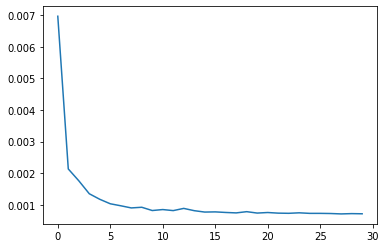

In [28]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [29]:
test_predictions = []

first_eval_batch = scaled_train_open[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predicted Close']=true_predictions

In [31]:
error1 = mean_squared_error(test['Predicted Close'], test['Close'])
error2 = rmse(test['Predicted Close'], test['Close'])
print(f'RNN MSE Error: {error1:11.10}')
print(f'RNN RMSE Error: {error2:11.10}')

RNN MSE Error: 314.4725568
RNN RMSE Error:  17.7333741


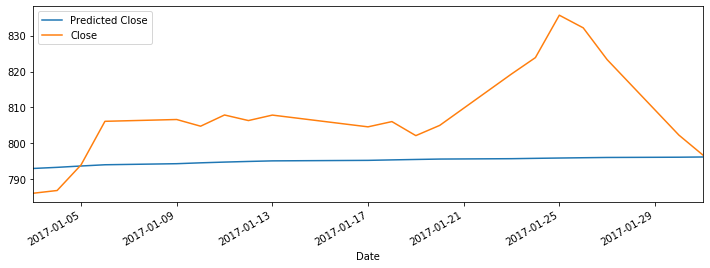

In [32]:
test['Predicted Close'].plot(figsize=(12,4),legend=True)
test['Close'].plot(figsize=(12,4),legend=True)